### Basic Recurrent Neural Network

Creating a basic RNN using the MNIST dataset. We normally don't use these for images, but just doing it for the learning purpose. 🤓

**Date:** 30/10/2021  
**Author:** Murad Popattia

In [1]:
# import libraries
import torch
import torch.nn as nn # all the layers
import torch.optim as optim # all the optimization algos
import torch.nn.functional as F # all the activation functions
from torch.utils.data import DataLoader # helps to create mini-batches etc.
import torchvision.datasets as datasets # for getting all datasets
import torchvision.transforms as transforms # for transformations on the dataset
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score

device = "cuda" if torch.cuda.is_available() else "cpu"

**Shape = ( N x 1 x 28 x 28 )** 

Where we can consider this to be 28 time sequences, where each sequence has 28 features

In [2]:
# hyper params
input_size = 28
sequence_length = 28 # can also be termed as time_steps
num_layers = 2
hidden_size = 256 # hidden state nodes
num_classes = 10
lr = 0.001
batch_size = 64
num_epochs = 2

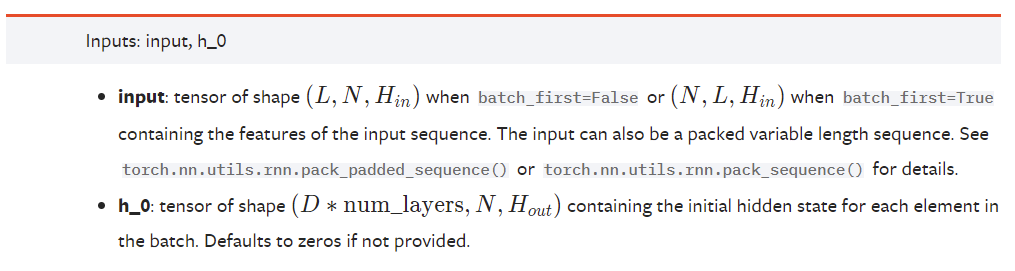
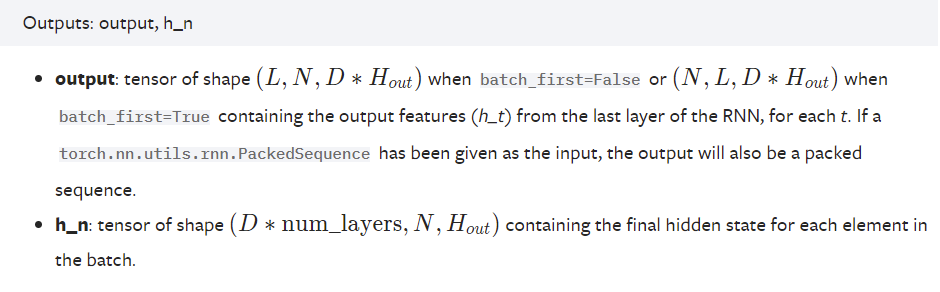

In [23]:
# Create an RNN
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) # batch_first means that the input will be (batch, seq, feats)
        self.fc = nn.Linear(hidden_size * sequence_length, num_classes) # we concatenate all the timesteps, or maybe utilize the last hidden state
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) # as per the documentation

        # forward prop
        # not storing the hiddnen state here
        out, _ = self.rnn(x, h0)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out) # output is like torch.Size([64, 28, 256]), for taking the last hidden state we can do out[:, -1, :]
        
        return out
    
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True) # batch_first means that the input will be (batch, seq, feats)
        self.fc = nn.Linear(hidden_size * sequence_length, num_classes) # we concatenate all the timesteps, or maybe utilize the last hidden state
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) # as per the documentation

        # forward prop
        # not storing the hiddnen state here
        out, _ = self.gru(x, h0)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        
        return out
    
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True) # batch_first means that the input will be (batch, seq, feats)
        self.fc = nn.Linear(hidden_size * sequence_length, num_classes) # we concatenate all the timesteps, or maybe utilize the last hidden state
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) # as per the documentation
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) # need to have cell state for LSTM
        
        # forward prop
        # not storing the hiddnen state here
        out, _ = self.lstm(x, (h0, c0)) # send these as a tuple
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        
        return out
    
class BRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes) # bidirectional hence hidden states maintained both sides
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) #
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)
        
        # forward prop
        out, _ = self.lstm(x, (h0, c0)) # send these as a tuple
        out = self.fc(out[:, -1, :]) # taking in the last hidden state
        
        return out

In [24]:
# checking the NN

model = BRNN(input_size, hidden_size, num_layers, num_classes).to(device)
features = torch.rand(64,28,28, device=device) # no. of examples
output = model(features)
print(output.shape) # output should be no. of examples x num_classes

torch.Size([64, 10])


In [25]:
train_dataset = datasets.MNIST(root='../datasets/', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=True)

test_dataset = datasets.MNIST(root='../datasets/', train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle=True)

In [26]:
model = RNN(input_size, hidden_size, num_layers, num_classes)
model1 = GRU(input_size, hidden_size, num_layers, num_classes).to(device)
model2 = LSTM(input_size, hidden_size, num_layers, num_classes).to(device)
model3 = BRNN(input_size, hidden_size, num_layers, num_classes).to(device)

In [27]:
from torchinfo import summary

summary(model, input_size=(len(train_loader),28,28))

Layer (type:depth-idx)                   Output Shape              Param #
RNN                                      --                        --
├─RNN: 1-1                               [938, 28, 256]            204,800
├─Linear: 1-2                            [938, 10]                 71,690
Total params: 276,490
Trainable params: 276,490
Non-trainable params: 0
Total mult-adds (G): 5.45
Input size (MB): 2.94
Forward/backward pass size (MB): 53.86
Params size (MB): 1.11
Estimated Total Size (MB): 57.91

In [28]:
summary(model1, input_size=(len(train_loader),28,28))

Layer (type:depth-idx)                   Output Shape              Param #
GRU                                      --                        --
├─GRU: 1-1                               [938, 28, 256]            614,400
├─Linear: 1-2                            [938, 10]                 71,690
Total params: 686,090
Trainable params: 686,090
Non-trainable params: 0
Total mult-adds (G): 16.20
Input size (MB): 2.94
Forward/backward pass size (MB): 53.86
Params size (MB): 2.74
Estimated Total Size (MB): 59.55

In [31]:
summary(model2, input_size=(len(train_loader),28,28))

Layer (type:depth-idx)                   Output Shape              Param #
LSTM                                     --                        --
├─LSTM: 1-1                              [938, 28, 256]            819,200
├─Linear: 1-2                            [938, 10]                 71,690
Total params: 890,890
Trainable params: 890,890
Non-trainable params: 0
Total mult-adds (G): 21.58
Input size (MB): 2.94
Forward/backward pass size (MB): 53.86
Params size (MB): 3.56
Estimated Total Size (MB): 60.37

In [32]:
summary(model3, input_size=(len(train_loader),28,28))

Layer (type:depth-idx)                   Output Shape              Param #
BRNN                                     --                        --
├─LSTM: 1-1                              [938, 28, 512]            2,162,688
├─Linear: 1-2                            [938, 10]                 5,130
Total params: 2,167,818
Trainable params: 2,167,818
Non-trainable params: 0
Total mult-adds (G): 56.81
Input size (MB): 2.94
Forward/backward pass size (MB): 107.65
Params size (MB): 8.67
Estimated Total Size (MB): 119.27

In [33]:
def train(_model):
    for epoch in range(num_epochs):  # 1 epoch means the model has seen all the images
        total_loss = 0
        counter = 0 

        n_batches = len(train_loader)
        print(f'Epoch {epoch+1}/{num_epochs}')
        pbar = tf.keras.utils.Progbar(target=n_batches)

        # Training
        _model.train()

        for idx, (data, target) in enumerate(train_loader):  # enumerating to see the batch idx

            # get data to cuda if possible
            data = data.to(device).squeeze(1) # we need to squeeze the dimension as the RNN is expecting (Nx28x28) and not (Nx1x28x28)
            target = target.to(device)

            # foward
            scores = _model(data)  
            loss = criterion(scores, target)
            total_loss += loss

            pbar.update(idx, values=[("loss",loss.item())])

            # backward
            optimizer.zero_grad()
            loss.backward()

            # gradient descent step
            optimizer.step()

            # increment for every batch
            counter += 1

        # for every epoch calculate test loss
        # validation
        _model.eval()

        for idx, (data, target) in enumerate(test_loader):
            with torch.no_grad(): # no computation for gradients
                # get data to cuda
                data = data.to(device).squeeze(1)
                target = target.to(device)

                scores = _model(data)
                loss = criterion(scores, target)

                pbar.update(idx, values=[("validation loss",loss.item())])

        pbar.update(n_batches, values=None)

In [120]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# training rnn
train(model)

Epoch 1/2
938/938 [==============================] - 12s 1ms/step - loss: 0.2900 - validation loss: 0.1552
Epoch 2/2
938/938 [==============================] - 12s 13ms/step - loss: 0.1319 - validation loss: 0.1077


In [121]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=lr)

train(model1)

Epoch 1/2
938/938 [==============================] - 13s 1ms/step - loss: 0.2013 - validation loss: 0.0683
Epoch 2/2
938/938 [==============================] - 13s 14ms/step - loss: 0.0659 - validation loss: 0.0709


In [122]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=lr)

train(model2)

Epoch 1/2
938/938 [==============================] - 13s 14ms/step - loss: 0.2243 - validation loss: 0.0713
Epoch 2/2
938/938 [==============================] - 14s 15ms/step - loss: 0.0647 - validation loss: 0.0551


In [35]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.parameters(), lr=lr)

train(model3)

Epoch 1/2
938/938 [==============================] - 21s 22ms/step - loss: 0.3681 - validation loss: 0.1443
Epoch 2/2
938/938 [==============================] - 21s 22ms/step - loss: 0.0981 - validation loss: 0.0702


In [36]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    output_gt = []
    output_pred = []
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device).squeeze(1)
            y = y.to(device)
            
            scores = model(x)
            _, predictions = scores.max(1) # .max() return max value and indices
            
            output_gt.extend(y.cpu().numpy())
            output_pred.extend(predictions.cpu().numpy())
        
        if (loader.dataset.train):
            print("Training Metrics: ")
        else:
            print("Testing Metrics: ")
        print(f'Precision: {precision_score(output_gt, output_pred, average="micro")}')
        print(f'Recall: {recall_score(output_gt, output_pred, average="micro")}')
        print(f'F1_score: {f1_score(output_gt, output_pred, average="micro")}')

In [124]:
check_accuracy(train_loader, model)
print()
check_accuracy(train_loader, model1)
print()
check_accuracy(train_loader, model2)
print()

Training Metrics: 
Precision: 0.9695
Recall: 0.9695
F1_score: 0.9695

Training Metrics: 
Precision: 0.9806666666666667
Recall: 0.9806666666666667
F1_score: 0.9806666666666667

Training Metrics: 
Precision: 0.9847333333333333
Recall: 0.9847333333333333
F1_score: 0.9847333333333333


In [125]:
check_accuracy(test_loader, model)
print()
check_accuracy(test_loader, model1)
print()
check_accuracy(test_loader, model2)

Testing Metrics: 
Precision: 0.9671
Recall: 0.9671
F1_score: 0.9671

Testing Metrics: 
Precision: 0.9803
Recall: 0.9803
F1_score: 0.9803

Testing Metrics: 
Precision: 0.9815
Recall: 0.9815
F1_score: 0.9815


In [38]:
check_accuracy(train_loader, model3)
print()
check_accuracy(test_loader, model3)

Training Metrics: 
Precision: 0.9811666666666666
Recall: 0.9811666666666666
F1_score: 0.9811666666666666

Testing Metrics: 
Precision: 0.9786
Recall: 0.9786
F1_score: 0.9786
